In [2]:
from imblearn.ensemble import BalancedBaggingClassifier
from imblearn.over_sampling import RandomOverSampler, SMOTE
from imblearn.under_sampling import RandomUnderSampler
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix, precision_recall_curve, roc_auc_score, auc, roc_curve
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, precision_score
import torch
import torch.nn as nn
import torch.optim as optim

In [3]:
df = pd.read_csv("output_dataset1.csv")
df.head()

,id,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,stroke
0,30669,Male,3.0,0,0,No,children,Rural,95.12,18.0,Unknown,0
1,30468,Male,58.0,1,0,Yes,Private,Urban,87.96,39.2,never smoked,0
2,16523,Female,8.0,0,0,No,Private,Urban,110.89,17.6,Unknown,0
3,56543,Female,70.0,0,0,Yes,Private,Rural,69.04,35.9,formerly smoked,0
4,46136,Male,14.0,0,0,No,Never_worked,Rural,161.28,19.1,Unknown,0


In [4]:
df['gender'] = df['gender'].map({'Male': 0, 'Female': 1, 'Other': 2})
df['ever_married'] = df['ever_married'].map({'No': 0, 'Yes': 1})
df['work_type'] = df['work_type'].map({'children': 0, 'Private': 1, 'Self-employed': 2, 'Govt_job': 3, 'Never_worked': 4})
df['Residence_type'] = df['Residence_type'].map({'Rural': 0, 'Urban': 1})
df['smoking_status'] = df['smoking_status'].map({'never smoked': 0, 'formerly smoked': 1, 'smokes': 2, 'Unknown' : 3})
df.head()

,id,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,stroke
0,30669,0,3.0,0,0,0,0,0,95.12,18.0,3,0
1,30468,0,58.0,1,0,1,1,1,87.96,39.2,0,0
2,16523,1,8.0,0,0,0,1,1,110.89,17.6,3,0
3,56543,1,70.0,0,0,1,1,0,69.04,35.9,1,0
4,46136,0,14.0,0,0,0,4,0,161.28,19.1,3,0


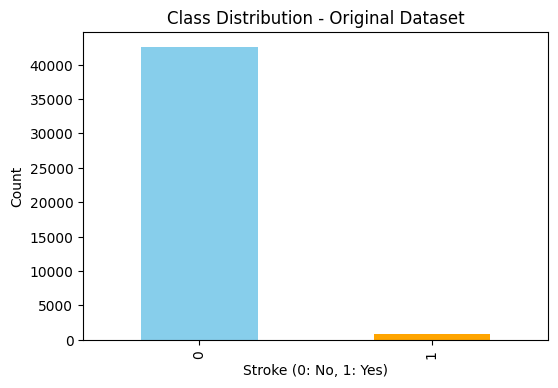

In [5]:
X = df[['gender', 'age', 'hypertension', 'heart_disease', 'ever_married', 'work_type', 'Residence_type', 'avg_glucose_level', 'bmi', 'smoking_status']]
y = df['stroke']
plt.figure(figsize=(6, 4))
df['stroke'].value_counts().plot(kind='bar', color=['skyblue', 'orange'])
plt.title('Class Distribution - Original Dataset')
plt.xlabel('Stroke (0: No, 1: Yes)')
plt.ylabel('Count')
plt.show()

In [6]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Standardize the features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Reshape the data for LSTM input
X_train_reshaped = X_train_scaled.reshape((X_train_scaled.shape[0], 1, X_train_scaled.shape[1]))
X_test_reshaped = X_test_scaled.reshape((X_test_scaled.shape[0], 1, X_test_scaled.shape[1]))

# Convert data to PyTorch tensors
X_train_tensor = torch.tensor(X_train_reshaped, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train.values, dtype=torch.float32).view(-1)
X_test_tensor = torch.tensor(X_test_reshaped, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test.values, dtype=torch.float32).view(-1)

In [7]:
class LSTMModel(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(LSTMModel, self).__init__()
        self.lstm = nn.LSTM(input_size, hidden_size, batch_first=True)
        self.fc = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        lstm_out, _ = self.lstm(x)
        out = self.fc(lstm_out[:, -1, :])
        out = torch.sigmoid(out.squeeze(dim=1))
        return out
# Instantiate the model
input_size = X_train_tensor.shape[2]
hidden_size = 64
output_size = 1
model = LSTMModel(input_size, hidden_size, output_size)

# Define loss function and optimizer
criterion = nn.BCELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Training the model
epochs = 100
for epoch in range(epochs):
    optimizer.zero_grad()
    outputs = model(X_train_tensor)
    loss = criterion(outputs, y_train_tensor)
    loss.backward()
    optimizer.step()

# Evaluation on the test set
with torch.no_grad():
    model.eval()
    test_outputs = model(X_test_tensor)
    predicted_labels = (test_outputs > 0.5).float()

accuracy = accuracy_score(y_test_tensor.numpy(), predicted_labels.numpy())
precision = precision_score(y_test_tensor.numpy(), predicted_labels.numpy())
confusion = confusion_matrix(y_test_tensor.numpy(), predicted_labels.numpy())

print("Original Model Metrics:")
print("Accuracy:", accuracy)
print("Precision:", precision)
print("Confusion Matrix:")
print(confusion)

Original Model Metrics:
Accuracy: 0.9814516129032258
Precision: 0.0
Confusion Matrix:
[[8519    0]
 [ 161    0]]


c:\Python310\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [8]:
def evaluate_model(model, X_test, y_test):
    with torch.no_grad():
        model.eval()
        test_outputs = model(X_test)
        predicted_labels = (test_outputs > 0.5).float()

    accuracy = accuracy_score(y_test.numpy(), predicted_labels.numpy())
    precision = precision_score(y_test.numpy(), predicted_labels.numpy())

    # Additional metrics
    confusion = confusion_matrix(y_test.numpy(), predicted_labels.numpy())
    fpr, tpr, _ = roc_curve(y_test.numpy(), test_outputs.numpy())
    precision_curve, recall_curve, _ = precision_recall_curve(y_test.numpy(), test_outputs.numpy())

    roc_auc = auc(fpr, tpr)
    pr_auc = auc(recall_curve, precision_curve)

    return accuracy, precision, confusion, roc_auc, pr_auc, precision_curve, recall_curve


In [9]:
# Helper function for plotting precision-recall curve
def plot_pr_curve(precision_curve, recall_curve, pr_auc, method, linestyle='-', color=None):
    plt.plot(recall_curve, precision_curve, label=f'{method} (AUC = {pr_auc:.2f})', linestyle=linestyle, color=color)


Random Oversampling Model Metrics:
Accuracy: 0.7232718894009217
Precision: 0.04909456740442656
Confusion Matrix:
[[6156 2363]
 [  39  122]]
ROC AUC: 0.8024831596745018
PR AUC: 0.06585952819125616
F1 Score: 0.09194785768608128

Random Undersampling Model Metrics:
Accuracy: 0.7100230414746543
Precision: 0.04934965570007651
Confusion Matrix:
[[6034 2485]
 [  32  129]]
ROC AUC: 0.8193989467460022
PR AUC: 0.06955708832187578
F1 Score: 0.09228509996806696

SMOTE Model Metrics:
Accuracy: 0.7341013824884792
Precision: 0.0540091400083091
Confusion Matrix:
[[6242 2277]
 [  31  130]]
ROC AUC: 0.8263177158255678
PR AUC: 0.06849348368814234
F1 Score: 0.10061579744299154


c:\Python310\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))



Weighted Loss Function Model Metrics:
Accuracy: 0.9814516129032258
Precision: 0.0
Confusion Matrix:
[[8519    0]
 [ 161    0]]
ROC AUC: 0.7887892536886857
PR AUC: 0.05510212612163659
F1 Score: 0.0


c:\Python310\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))



Ensemble of Resampling Methods Model Metrics:
Accuracy: 0.9814516129032258
Precision: 0.0
Confusion Matrix:
[[8519    0]
 [ 161    0]]
ROC AUC: 0.8095539455466372
PR AUC: 0.060537519900627626
F1 Score: 0.0


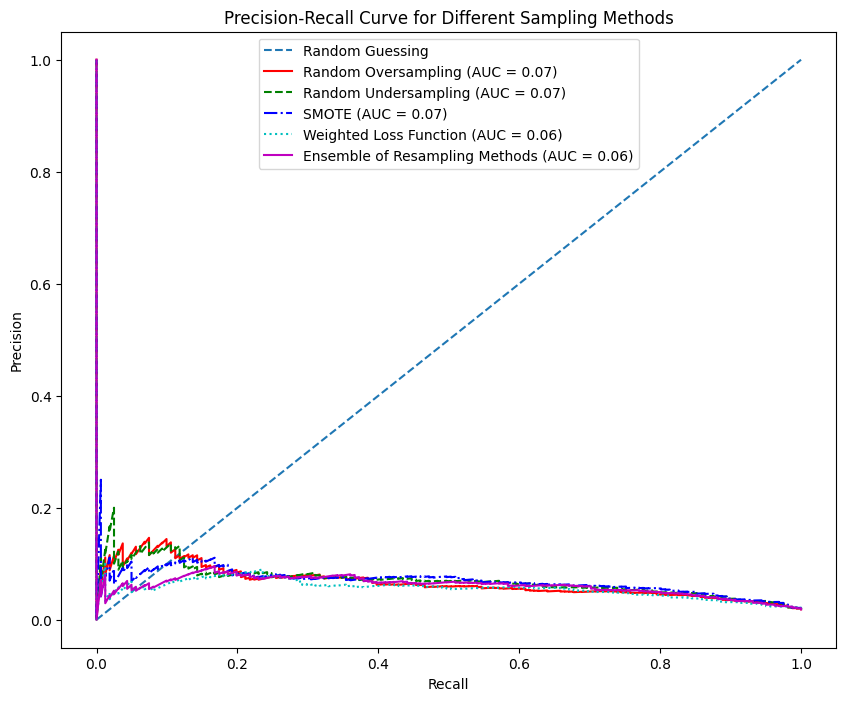

In [10]:
methods = ['Random Oversampling', 'Random Undersampling','SMOTE' , 'Weighted Loss Function', 'Ensemble of Resampling Methods']
classifiers = [
    RandomOverSampler(random_state=42),
    RandomUnderSampler(random_state=42),
    SMOTE(random_state=42),
    None,
    BalancedBaggingClassifier(base_estimator=RandomForestClassifier(), n_estimators=10, random_state=42)
]

best_method = None
best_f1_score = 0.0

# Plotting all precision-recall curves
plt.figure(figsize=(10, 8))
plt.plot([0, 1], [0, 1], linestyle='--', label='Random Guessing')
for method, classifier, linestyle, color in zip(methods, classifiers, ['-', '--', '-.', ':', '-'], ['r', 'g', 'b', 'c', 'm']):
    if classifier is not None and method != 'Ensemble of Resampling Methods':
        X_resampled, y_resampled = classifier.fit_resample(X_train_tensor.numpy().reshape(-1, input_size), y_train_tensor.numpy())
        X_resampled = torch.tensor(X_resampled.reshape(-1, 1, input_size), dtype=torch.float32)
        y_resampled = torch.tensor(y_resampled, dtype=torch.float32).view(-1)
    else:
        X_resampled, y_resampled = X_train_tensor, y_train_tensor

    # Train the model on resampled data
    for epoch in range(epochs):
        optimizer.zero_grad()
        outputs = model(X_resampled)
        loss = criterion(outputs, y_resampled)
        loss.backward()
        optimizer.step()

    # Evaluate the model on the test set after resampling
    with np.errstate(divide='ignore', invalid='ignore'):
        accuracy, precision, confusion, roc_auc, pr_auc, precision_curve, recall_curve = evaluate_model(model, X_test_tensor, y_test_tensor)

    # Calculate F1 score
    f1_score = 2 * (precision * accuracy) / (precision + accuracy)

    # Print metrics for each method
    print(f"\n{method} Model Metrics:")
    print("Accuracy:", accuracy)
    print("Precision:", precision)
    print("Confusion Matrix:")
    print(confusion)
    print("ROC AUC:", roc_auc)
    print("PR AUC:", pr_auc)
    print("F1 Score:", f1_score)

    # Plot precision-recall curve for each method
    plot_pr_curve(precision_curve, recall_curve, pr_auc, method, linestyle=linestyle, color=color)

    # Update best method based on F1 score
    if f1_score > best_f1_score:
        best_f1_score = f1_score
        best_method = method
# Print the best class imbalance method

# Customize the plot
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve for Different Sampling Methods')
plt.legend()
plt.show()

In [11]:
print(f"\nBest Class Imbalance Method: {best_method} (F1 Score = {best_f1_score:.4f})")



Best Class Imbalance Method: SMOTE (F1 Score = 0.1006)


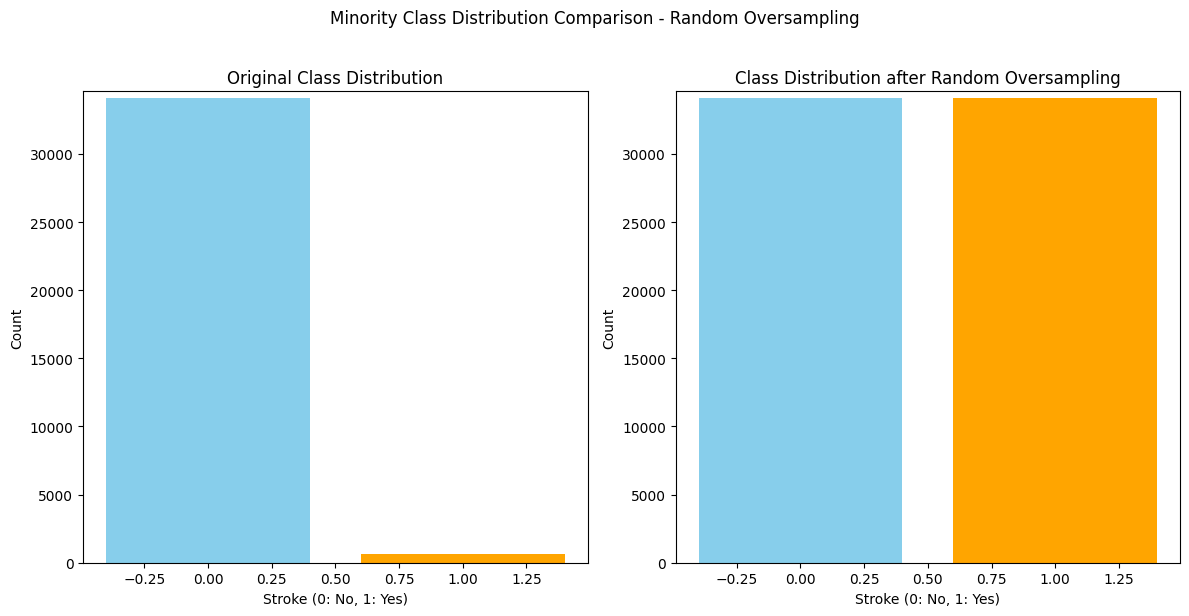

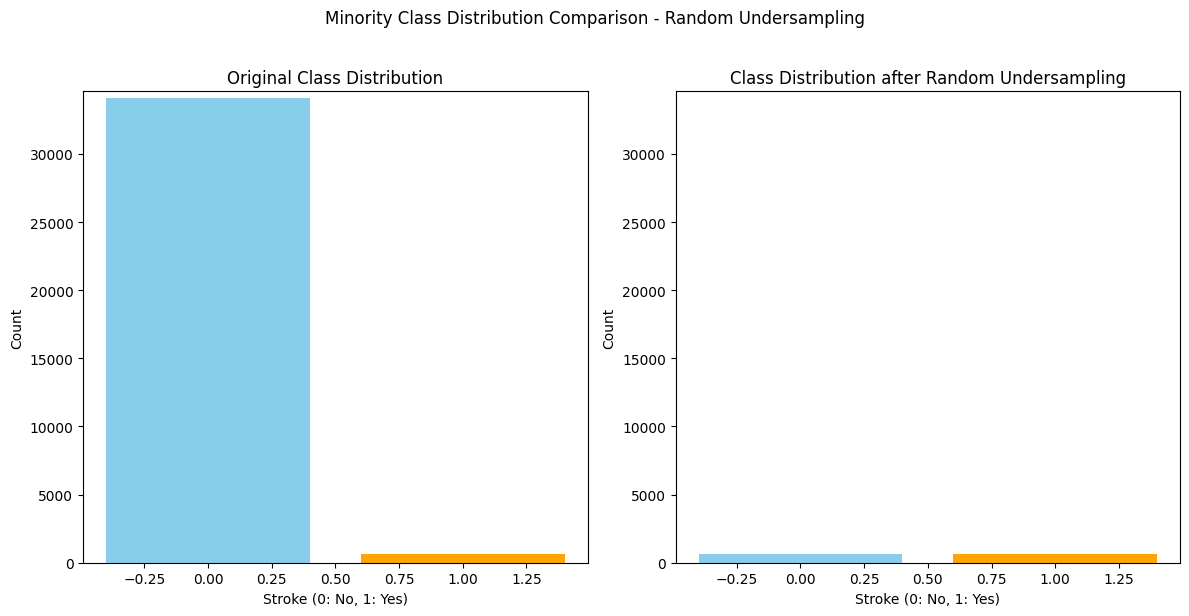

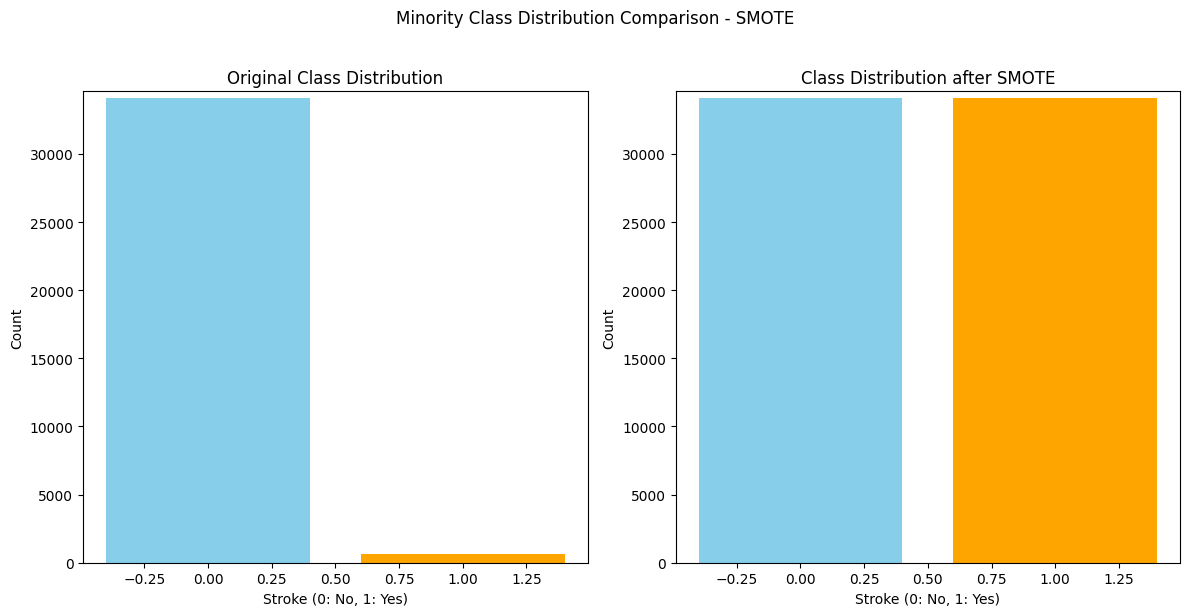

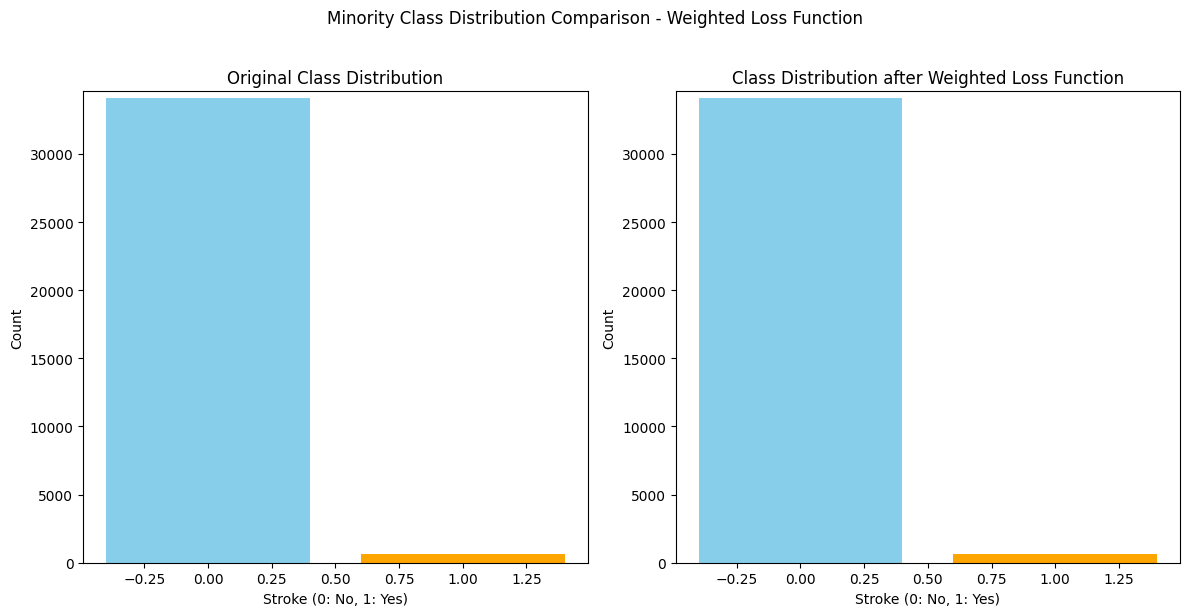

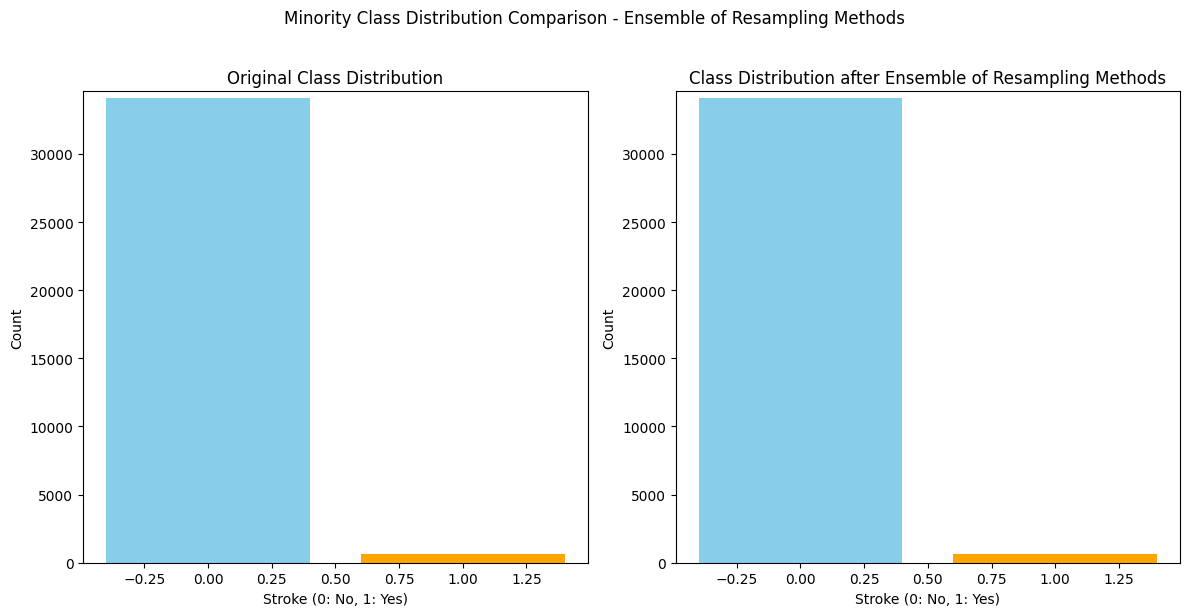

In [12]:
def plot_minority_class_count(X_original, y_original, X_resampled, y_resampled, method, color):
    plt.figure(figsize=(12, 6))

    # Plot original minority class count
    plt.subplot(1, 2, 1)
    plt.bar([0, 1], [len(y_original[y_original == 0]), len(y_original[y_original == 1])], color=['skyblue', 'orange'])
    plt.title('Original Class Distribution')
    plt.xlabel('Stroke (0: No, 1: Yes)')
    plt.ylabel('Count')
    plt.ylim(0, max(len(y_original[y_original == 0]), len(y_original[y_original == 1])) + 500)

    # Plot resampled minority class count
    plt.subplot(1, 2, 2)
    plt.bar([0, 1], [len(y_resampled[y_resampled == 0]), len(y_resampled[y_resampled == 1])], color=['skyblue', 'orange'])
    plt.title(f'Class Distribution after {method}')
    plt.xlabel('Stroke (0: No, 1: Yes)')
    plt.ylabel('Count')
    plt.ylim(0, max(len(y_original[y_original == 0]), len(y_original[y_original == 1])) + 500)

    # Show the plot
    plt.suptitle(f'Minority Class Distribution Comparison - {method}', y=1.02)
    plt.tight_layout()
    plt.show()

# Additional setup
X_original, y_original = X_train_tensor.numpy().reshape(-1, input_size), y_train_tensor.numpy()

# Add the new method for plotting minority class count
for method, classifier, linestyle, color in zip(methods, classifiers, ['-', '--', '-.', ':', '-'], ['r', 'g', 'b', 'c', 'm']):
    if classifier is not None and method != 'Ensemble of Resampling Methods':
        X_resampled, y_resampled = classifier.fit_resample(X_original, y_original)
        X_resampled = torch.tensor(X_resampled.reshape(-1, 1, input_size), dtype=torch.float32)
        y_resampled = torch.tensor(y_resampled, dtype=torch.float32).view(-1)
    else:
        X_resampled, y_resampled = X_train_tensor, y_train_tensor

    # Call the new method to plot minority class count
    plot_minority_class_count(X_original, y_original, X_resampled.numpy().reshape(-1, input_size), y_resampled.numpy(), method, color)